In [1]:
import sys
sys.path.append('/home/daniel/wizepair2')

In [2]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import SaltRemover
#rom networkx import to_numpy_matrix
from mmpa.mmp import MMP

from tqdm import tqdm
tqdm.pandas()

## Part 1: Dataset summary and preparation.

### Import all activity values from Glen's HDAC paper into a pandas dataframe.

https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/document_chembl_id%3ACHEMBL1144843

In [3]:
df = pd.read_csv('/home/daniel/Downloads/DOWNLOAD-yHB7WOyNM1ncO7P50KZYChBxehUvIU9pGeCACYqyD4Y=.zip', sep=';', compression='zip')

### Summarise the most common molecules.

In [15]:
df[['Molecule ChEMBL ID', 'Compound Key']].value_counts()[0:10]

Molecule ChEMBL ID  Compound Key
CHEMBL403813        13b             23
CHEMBL403812        13d             11
CHEMBL402208        13a             11
CHEMBL258177        15b             11
CHEMBL256985        14b             11
CHEMBL257176        3                9
CHEMBL402542        14c              7
CHEMBL258176        15a              7
CHEMBL258175        15c              6
CHEMBL256998        15d              6
dtype: int64

### Summarise the most common targets.

In [9]:
df[['Target Name', 'Assay ChEMBL ID', 'Standard Type', 'Standard Units']].value_counts()[0:10]

Target Name            Assay ChEMBL ID  Standard Type  Standard Units
Histone deacetylase 1  CHEMBL927948     IC50           nM                13
HERG                   CHEMBL927950     IC50           nM                13
HCT-116                CHEMBL927949     IC50           nM                13
No relevant target     CHEMBL927951     Solubility     nM                12
Rattus norvegicus      CHEMBL927956     AUC            hr.Kg/L            4
                       CHEMBL927955     Vdss           L.kg-1             4
                       CHEMBL927953     CL             mL.min-1.kg-1      4
                       CHEMBL927954     T1/2           hr                 3
                       CHEMBL927959     Vdss           L.kg-1             2
                       CHEMBL922557     AUC            hr.Kg/L            2
dtype: int64

### Strip salts from the molecular structures.

In [6]:
def strip_salts(smiles):
    
    # parse smiles as rdkit molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # remove salts
    remover = SaltRemover.SaltRemover()
    mol, salts = remover.StripMolWithDeleted(mol)
    smiles = Chem.MolToSmiles(mol)
    
    # return
    return smiles

In [26]:
df['Stripped'] = df.Smiles.apply(strip_salts)
df.Stripped.unique().size

13

### Remove a 'test set' from MMPA phase to use later in validation.

In [27]:
training = ~df['Compound Key'].isin(['13c', '14d'])

## Part 2: Perform Matched Molecular Pair Analysis (MMPA).

### Create cartesian product of unique molecules test in the same assay.

In [28]:
df_pairs = pd.merge(df[training], df[training], on='Assay ChEMBL ID')
df_pairs = df_pairs[['Stripped_x', 'Stripped_y']].drop_duplicates()
df_pairs

,Stripped_x,Stripped_y
0,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...
1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...
2,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...
3,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
4,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...
...,...,...
116,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
117,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Cc1cc(CN2CCN(C(C)C)CC2)cnc1-c1ccc(C(=O)Nc2cccc...
118,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1
119,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1


### Identify pairs all pairs and discard failures.

In [29]:
def apply_mmpa(prospective_pair):

    # prepare potential atom-atom mappings and create correspondence graph
    mmp = MMP(prospective_pair.Stripped_x, prospective_pair.Stripped_y, fuzziness=5)
    mmp.createCorrespondence()
    mmp.findCliques()
    mmp.eliminateMCS(radius=3)
    
    # append frags to output
    prospective_pair['Fragment_x'] = mmp.getFragment1()
    prospective_pair['Fragment_y'] = mmp.getFragment2()
    prospective_pair['SMIRKS'] = mmp.getSmirks()
    prospective_pair['PercentMCS'] = mmp.getPercentMCS()
    
    # return
    return prospective_pair

In [30]:
df_pairs = df_pairs.progress_apply(apply_mmpa, axis=1)
df_pairs = df_pairs[~pd.isna(df_pairs.SMIRKS)]
df_pairs.sample(3).transpose()

100%|██████████| 121/121 [03:06<00:00,  1.54s/it]


,31,69,6
Stripped_x,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(Cl...
Stripped_y,Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
Fragment_x,[cH3]-[c]([nH])[c]([F])[cH][cH][CH2][N]1[CH2][...,[CH3][c]1[cH][cH][cH][n][cH]1,[CH3][CH2][N]1[CH2][CH2][N]([CH2][c]2[cH][n][c...
Fragment_y,[cH3]-[c]([nH])[c]([CH3])[cH][cH][CH2][N]1[CH2...,[CH3][c]1[cH][n][cH][c]([CH2][N]2[CH2][CH2][CH...,[cH3]-[c]1[n][cH][cH][cH][c]1[C]#[N]
SMIRKS,[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[#7]1-[#6](...,[#6:24]-[#6:21]1:[#6:23](:[#6:18](:[#6:22](:[#...,[#6](-[#6](-[#7]1-[#6](-[#6](-[#7](-[#6](-[#6:...
PercentMCS,85.2459,86.7925,75


### Perform quality control by demonstrating x -> y using encoded reaction.

In [33]:
def apply_reactions(reaction):
    
    # create reaction
    rxn = Chem.rdChemReactions.ReactionFromSmarts(reaction.SMIRKS)

    # enumerate products
    productset = rxn.RunReactants((Chem.AddHs(Chem.MolFromSmiles(reaction.Stripped_x)),))

    # create a list of all possible products as smiles
    productlist = []
    for product in productset:
        productlist.append('.'.join([Chem.MolToSmiles(Chem.RemoveHs(productpart)) for productpart in product]))
    return list(set(productlist))

In [34]:
df_pairs['ProductList'] = df_pairs.progress_apply(apply_reactions, axis=1)
df_pairs.sample(3).transpose()

100%|██████████| 92/92 [00:21<00:00,  4.34it/s]


,119,95,69
Stripped_x,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
Stripped_y,Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,Cc1cc(CN2CCN(C(C)C)CC2)cnc1-c1ccc(C(=O)Nc2cccc...,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1
Fragment_x,[cH3]-[c]([nH])[c]([Cl])[cH][cH][CH2][N]1[CH2]...,[cH3]-[c]([nH])[c]([F])[cH][cH][CH2][N]1[CH2][...,[CH3][c]1[cH][cH][cH][n][cH]1
Fragment_y,[cH3]-[c]([nH])[c]([CH3])[cH][cH][CH2][N]1[CH2...,[cH3]-[c]([nH])[c]([CH3])[cH][cH][CH2][N]1[CH2...,[CH3][c]1[cH][n][cH][c]([CH2][N]2[CH2][CH2][CH...
SMIRKS,[#6](-[#6](-[#6](-[H])(-[H])-[H])(-[#7]1-[#6](...,[#6:1]-[#6:10](:[#7:18]):[#6:22](:[#6:19](:[#6...,[#6:24]-[#6:21]1:[#6:23](:[#6:18](:[#6:22](:[#...
PercentMCS,85.2459,85.2459,86.7925
ProductList,[Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1],[Cc1cc(CN2CCN(C(C)C)CC2)cnc1-c1ccc(C(=O)Nc2ccc...,[N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1]


### Check all y structures have been reproduced (essential) without multiple products (optional).

In [14]:
df_pairs.apply(lambda x: x.Stripped_y not in x.ProductList, axis=1).sum()

0

In [15]:
df_pairs.ProductList.apply(lambda x: len(x) > 1).sum()

0

## Part 3: Reunite with activity data and summarise effects of changes.

### Copy logD values over to 'pCHEMBL Value' column for later comparison.

In [ ]:
df_exact = df[['Stripped', 'Assay ChEMBL ID', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value']].copy()
df_exact['pChEMBL Value'] = df_exact.apply(lambda x: x['Standard Value'] if x['Standard Type'] == 'LogD' else x['pChEMBL Value'], axis=1)

### Filter exact measurements only.

In [ ]:
df_exact = df_exact[(df_exact['Standard Relation']=="'='") & (pd.notna(df_exact['pChEMBL Value']))]
df_exact.sample(3).transpose()

### Combine twice with confirmed molecular pairs.

In [17]:
df_merge = df_pairs.merge(df_exact, left_on='Stripped_x', right_on='Stripped')
df_merge = df_merge.merge(df_exact, left_on=['Stripped_y', 'Assay ChEMBL ID'], right_on=['Stripped', 'Assay ChEMBL ID'])
df_merge['pChEMBL Value_delta'] = df_merge['pChEMBL Value_y'] - df_merge['pChEMBL Value_x'] 
df_merge.sample(3).transpose()

,59,46,168
Stripped_x,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1
Stripped_y,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C)...,CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C#...,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...
Fragment_x,[cH3]-[c]([nH])[c]([C]#[N])[cH][cH][CH2][N]1[C...,[CH3][N]1[CH2][CH2][CH2]1,[cH3]-[c]([nH])[c]([F])[cH][cH][CH2][N]1[CH2][...
Fragment_y,[CH3][CH2][N]1[CH2][CH2][N]([CH2][cH][cH][c]([...,[CH3][CH2][N]1[CH2][CH2][N]([CH3])[CH2][CH2]1,[cH3]-[c]([nH])[c]([Cl])[cH][cH][CH2][N]1[CH2]...
SMIRKS,[#7]#[#6:25]-[#6:24](:[#6:23](:[#6:13]-[#6:15]...,[#6:13](-[#7:15]1-[#6:16](-[#6](-[#6:17]-1(-[H...,[#6:1]-[#6:11](:[#7:21]):[#6:18](:[#6:22](:[#6...
PercentMCS,85.2459,90.3226,85.2459
ProductList,[CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C...,[CCN1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c(C...,[CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)...
Stripped_x,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,N#Cc1cc(CN2CCC2)cnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,Nc1ccccc1NC(=O)c1ccc(-c2ncc(CN3CCC3)cc2F)cc1
Assay ChEMBL ID,CHEMBL927952,CHEMBL927949,CHEMBL927948
Standard Type_x,LogD,IC50,IC50


### Filter mcs > 90% and aggregate by the two fragments.

In [18]:
df_agg = df_merge[df_merge.PercentMCS > 90]
df_agg = pd.pivot_table(df_agg, values='pChEMBL Value_delta', index=['Fragment_x', 'Fragment_y'], columns='Assay ChEMBL ID', aggfunc=['count','mean'])
df_agg.columns = [' '.join(col).strip() for col in df_agg.columns.values]
df_agg

count CHEMBL927948  \
Fragment_x                                    Fragment_y                                                          
[CH3][CH2][N]([CH2][CH3])[CH2][CH3]           [CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3]                     3.0   
[CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3]     [CH3][CH2][N]([CH2][CH3])[CH2][CH3]                           3.0   
[CH3][CH2][N]1[CH2][CH2][N]([CH3])[CH2][CH2]1 [CH3][N]1[CH2][CH2][CH2]1                                     1.0   
[CH3][N]1[CH2][CH2][CH2]1                     [CH3][CH2][N]1[CH2][CH2][N]([CH3])[CH2][CH2]1                 1.0   
[cH2][cH][c]([CH3])[c](-[cH3])[nH]            [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]                          3.0   
                                              [cH2][cH][c]([Cl])[c](-[cH3])[nH]                             2.0   
                                              [cH2][cH][c]([F])[c](-[cH3])[nH]                              2.0   
[cH2][cH][c]([C]#[N])[c](-[cH3])[nH]          [cH2][cH][c]([CH3])[c](-[cH3])[nH]                            3.0   
                                              [cH2][cH][c]([Cl])[c](-[cH3])[nH]                             2.0   
                                              [cH2][cH][c]([F])[c](-[cH3])[nH]                              2.0   
[cH2][cH][c]([Cl])[c](-[cH3])[nH]             [cH2][cH][c]([CH3])[c](-[cH3])[nH]                            2.0   
                                              [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]                          2.0   
                                              [cH2][cH][c]([F])[c](-[cH3])[nH]                              1.0   
[cH2][cH][c]([F])[c](-[cH3])[nH]              [cH2][cH][c]([CH3])[c](-[cH3])[nH]                            2.0   
                                              [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]                          2.0   
                                              [cH2][cH][c]([Cl])[c](-[cH3])[nH]                             1.0   

                                                                                             count CHEMBL927949  \
Fragment_x                                    Fragment_y                                                          
[CH3][CH2][N]([CH2][CH3])[CH2][CH3]           [CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3]                     3.0   
[CH3][CH2][N]([CH2][CH3])[CH]([CH3])[CH3]     [CH3][CH2][N]([CH2][CH3])[CH2][CH3]                           3.0   
[CH3][CH2][N]1[CH2][CH2][N]([CH3])[CH2][CH2]1 [CH3][N]1[CH2][CH2][CH2]1                                     1.0   
[CH3][N]1[CH2][CH2][CH2]1                     [CH3][CH2][N]1[CH2][CH2][N]([CH3])[CH2][CH2]1                 1.0   
[cH2][cH][c]([CH3])[c](-[cH3])[nH]            [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]                          3.0   
                                              [cH2][cH][c]([Cl])[c](-[cH3])[nH]                             2.0   
                                              [cH2][cH][c]([F])[c](-[cH3])[nH]                              2.0   
[cH2][cH][c]([C]#[N])[c](-[cH3])[nH]          [cH2][cH][c]([CH3])[c](-[cH3])[nH]                            3.0   
                                              [cH2][cH][c]([Cl])[c](-[cH3])[nH]                             2.0   
                                              [cH2][cH][c]([F])[c](-[cH3])[nH]                              2.0   
[cH2][cH][c]([Cl])[c](-[cH3])[nH]             [cH2][cH][c]([CH3])[c](-[cH3])[nH]                            2.0   
                                              [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]                          2.0   
                                              [cH2][cH][c]([F])[c](-[cH3])[nH]                              1.0   
[cH2][cH][c]([F])[c](-[cH3])[nH]              [cH2][cH][c]([CH3])[c](-[cH3])[nH]                            2.0   
                                              [cH2][cH][c]([C]#[N])[c](-[cH3])[nH]                          2.0   
                                              [cH2][cH][c]([Cl])[c]

### ...and finally plot (figure 3 from wizepairz paper)

In [19]:
%matplotlib inline

<AxesSubplot:xlabel='mean CHEMBL927952', ylabel='mean CHEMBL927948'>

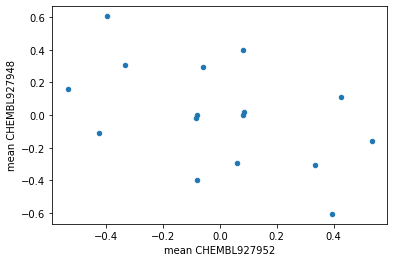

In [20]:
df_agg.plot.scatter('mean CHEMBL927952', 'mean CHEMBL927948')